In [142]:
!pip install tensorflow

In [143]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Data

In [144]:
sns.set(style="whitegrid")

In [145]:
tickers = {
    "S&P 500": "^GSPC",
    "Dow Jones": "^DJI",
    "Nasdaq": "^NDX"
}
data_dict = {}

for name, symbol in tickers.items():
    ticker = yf.Ticker(symbol)
    hist = ticker.history(period="8y")  # 2023 + 2024
    hist.reset_index(inplace=True)
    hist = hist[["Date", "Close"]]
    data_dict[name] = hist

In [146]:
def split_data(df):
    train = df[df["Date"] < "2025-04-01"]
    test = df[df["Date"] >= "2025-04-01"]
    return train.reset_index(drop=True), test.reset_index(drop=True)

def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred) * 100
    }

def plot_prediction(dates, actual, predicted, title):
    plt.figure(figsize=(10, 4))
    plt.plot(dates, actual, label="Thực tế")
    plt.plot(dates, predicted, label="Dự đoán")
    plt.title(title)
    plt.xlabel("Ngày")
    plt.ylabel("Giá đóng cửa")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ARIMA

In [147]:
def run_arima(train, test, order=(5,1,0)):
    history = list(pd.to_numeric(train["Close"], errors='coerce').dropna())
    predictions = []
    true_values = []
    test_values = list(pd.to_numeric(test["Close"], errors='coerce').dropna())

    for t in range(len(test_values)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=1)[0]
        predictions.append(yhat)
        true_values.append(test_values[t])
        history.append(test_values[t])

    return predictions, true_values



# SVM

In [148]:
def run_svm(train, test):
    scaler = MinMaxScaler()
    full_data = pd.concat([train, test]).reset_index(drop=True)
    predictions = []
    true_values = []

    for i in range(len(train), len(full_data)):
        window = full_data.iloc[:i]
        X = np.arange(len(window)).reshape(-1, 1)
        y_scaled = scaler.fit_transform(window[["Close"]]).ravel()

        model = SVR(kernel='rbf')
        model.fit(X, y_scaled)

        X_pred = np.array([[len(window)]])
        y_pred_scaled = model.predict(X_pred)
        y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()[0]

        predictions.append(y_pred)
        true_values.append(full_data["Close"].iloc[i])

    return np.array(true_values), np.array(predictions)


# LSTM

In [149]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

def run_lstm(train, test, seq_len=30):
    scaler = MinMaxScaler()
    full_data = pd.concat([train, test]).reset_index(drop=True)
    predictions = []
    true_values = []

    for i in range(len(train), len(full_data)):
        window = full_data.iloc[:i]
        window_scaled = scaler.fit_transform(window[["Close"]])

        if len(window_scaled) <= seq_len:
            continue

        X_train, y_train = create_sequences(window_scaled, seq_len)
        X_train = X_train.reshape((X_train.shape[0], seq_len, 1))

        model = Sequential([
            LSTM(50, return_sequences=False, input_shape=(seq_len, 1)),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=5, batch_size=16, verbose=0)

        # Predict next
        last_seq = window_scaled[-seq_len:].reshape((1, seq_len, 1))
        y_pred = model.predict(last_seq)[0][0]
        y_pred_rescaled = scaler.inverse_transform([[y_pred]])[0][0]

        predictions.append(y_pred_rescaled)
        true_values.append(full_data["Close"].iloc[i])

    return np.array(true_values), np.array(predictions)


# Prophet

In [150]:
def run_prophet(train, test):
    train['Date'] = train['Date'].dt.tz_localize(None)
    test['Date'] = test['Date'].dt.tz_localize(None)

    df = train[["Date", "Close"]].rename(columns={"Date": "ds", "Close": "y"})
    model = Prophet(daily_seasonality=False)
    model.fit(df)
    future = pd.DataFrame({"ds": test["Date"]})
    forecast = model.predict(future)
    return test["Close"].values, forecast["yhat"].values

# So sánh và đánh giá


 Đang xử lý: S&P 500


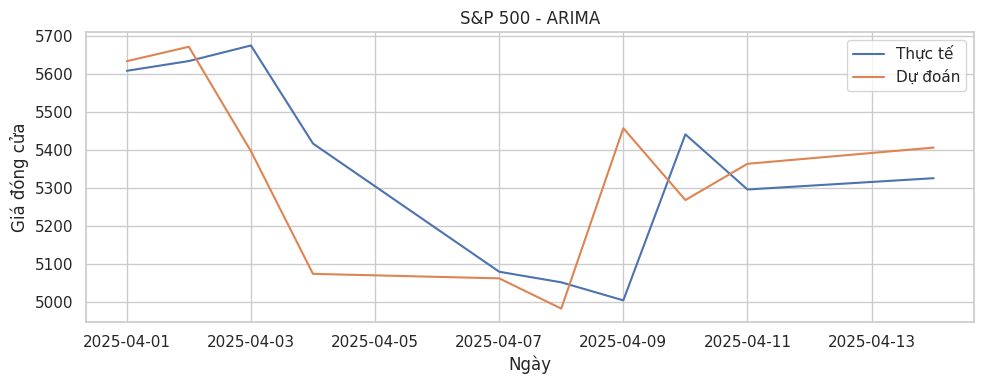

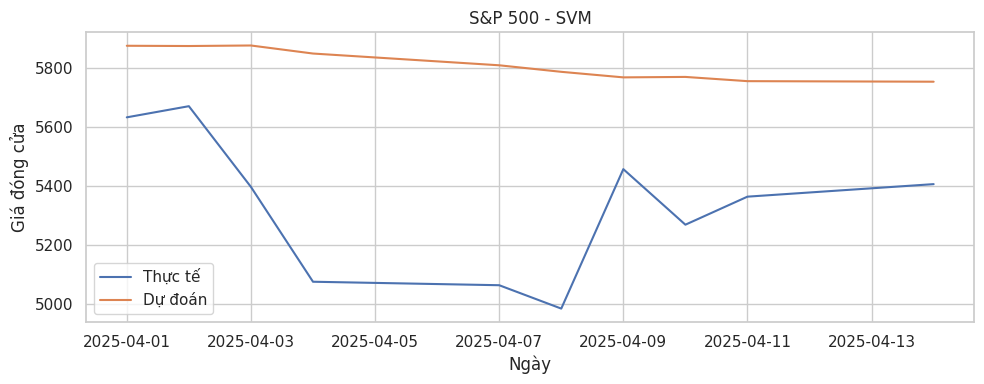

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


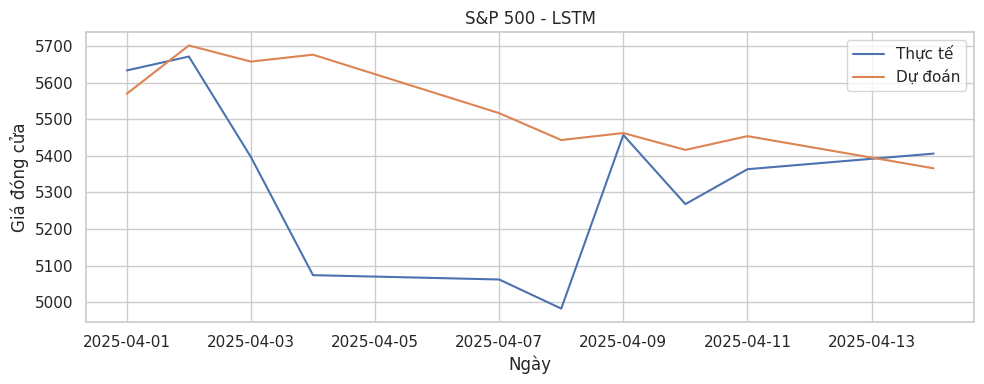

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71xxcv5v/8zm3xvho.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71xxcv5v/oqjhxaj8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90259', 'data', 'file=/tmp/tmp71xxcv5v/8zm3xvho.json', 'init=/tmp/tmp71xxcv5v/oqjhxaj8.json', 'output', 'file=/tmp/tmp71xxcv5v/prophet_model6gu0lsba/prophet_model-20250415082411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:24:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:24:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


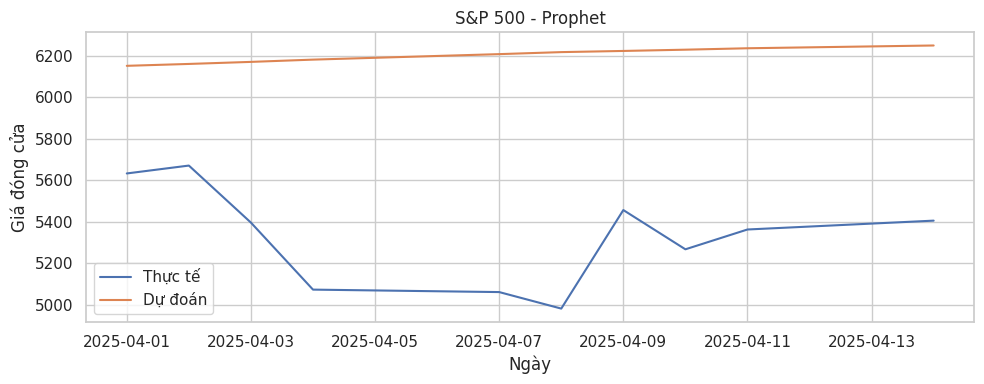


 Đang xử lý: Dow Jones


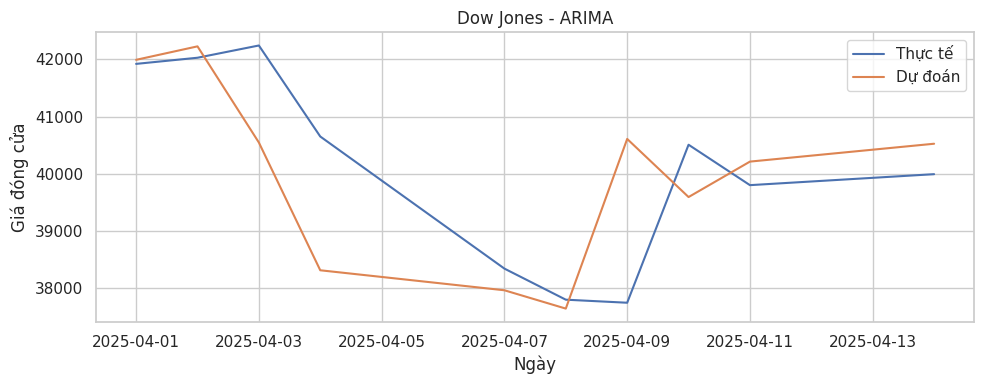

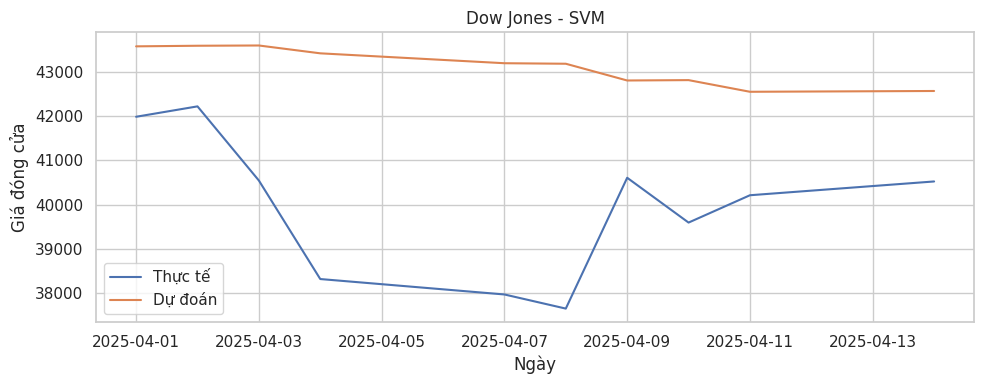

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


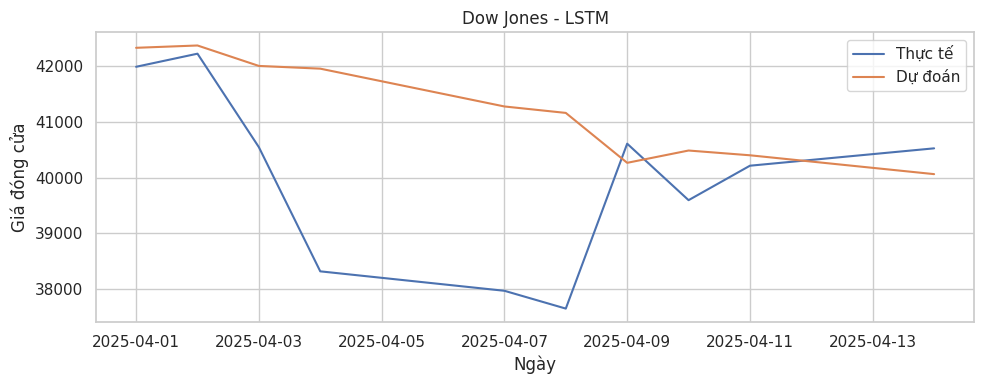

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71xxcv5v/yra8o_c8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71xxcv5v/l3x3gt81.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17288', 'data', 'file=/tmp/tmp71xxcv5v/yra8o_c8.json', 'init=/tmp/tmp71xxcv5v/l3x3gt81.json', 'output', 'file=/tmp/tmp71xxcv5v/prophet_modelll7t43qm/prophet_model-20250415082612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:26:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:26:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


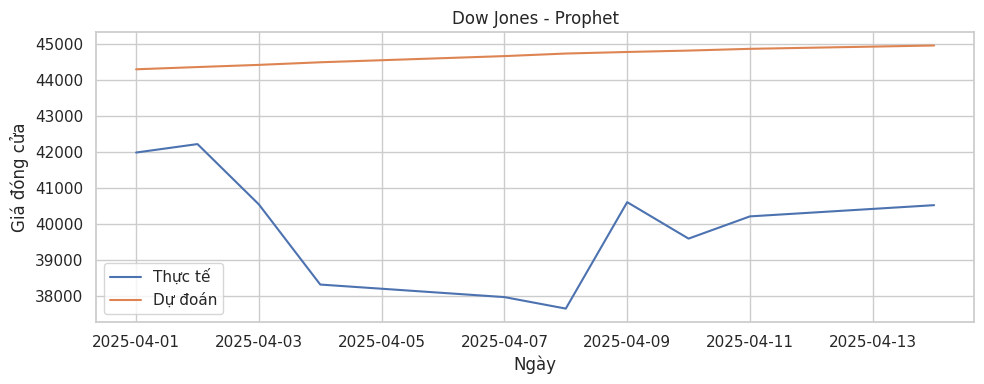


 Đang xử lý: Nasdaq


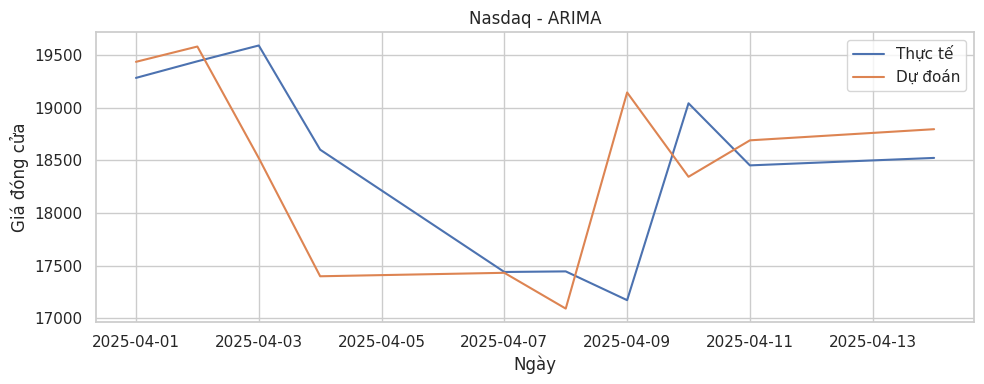

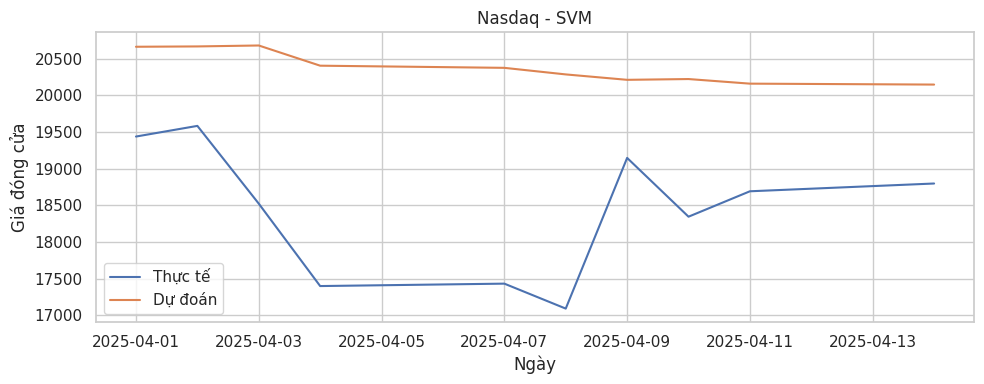

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


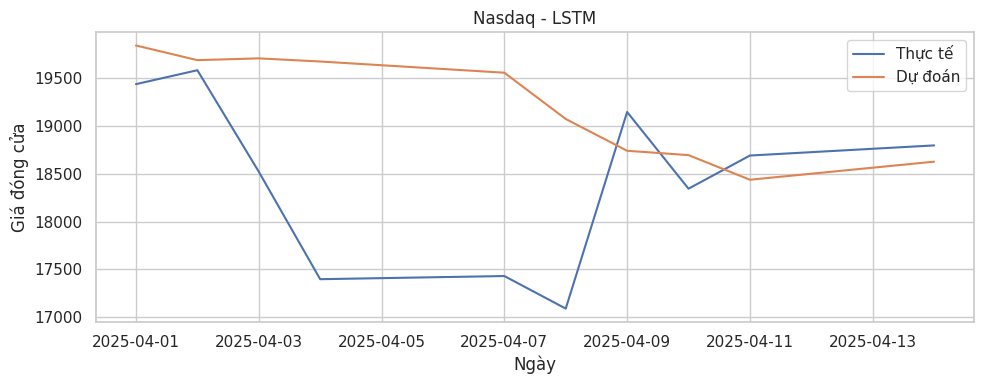

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71xxcv5v/azg_wgh9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71xxcv5v/hl8jpu3c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33135', 'data', 'file=/tmp/tmp71xxcv5v/azg_wgh9.json', 'init=/tmp/tmp71xxcv5v/hl8jpu3c.json', 'output', 'file=/tmp/tmp71xxcv5v/prophet_modelu2nujqyj/prophet_model-20250415082757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


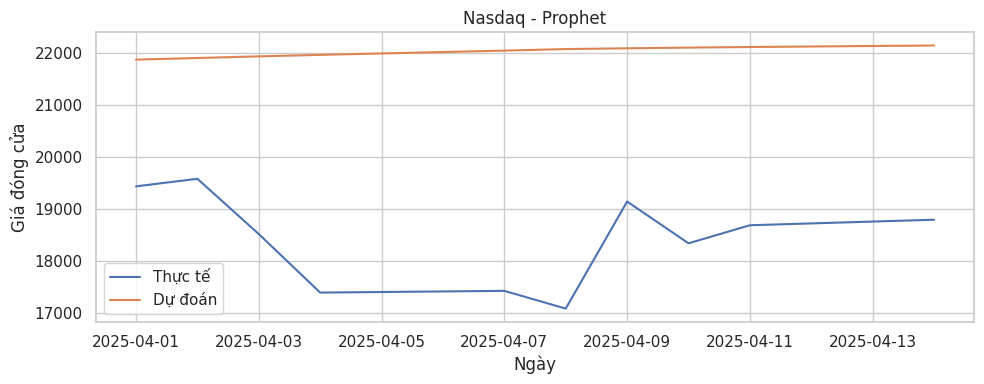

In [151]:
results = {}

for name, df in data_dict.items():
    print(f"\n Đang xử lý: {name}")
    train, test = split_data(df)
    res = {}

    for method, func in {
        "ARIMA": run_arima,
        "SVM": run_svm,
        "LSTM": run_lstm,
        "Prophet": run_prophet
    }.items():
        actual, pred = func(train, test)
        score = evaluate(actual[:len(pred)], pred)
        res[method] = score
        plot_prediction(test["Date"][:len(pred)], actual[:len(pred)], pred, f"{name} - {method}")

    results[name] = res


In [152]:
summary = {}

for method in ["ARIMA", "SVM", "LSTM", "Prophet"]:
    metrics = ["MAE", "MSE", "RMSE", "MAPE"]
    summary[method] = {}
    for metric in metrics:
        vals = [results[index][method][metric] for index in results]
        summary[method][metric] = np.mean(vals)

pd.DataFrame(summary)


,ARIMA,SVM,LSTM,Prophet
MAE,573.566865,1.863946e+03,8.570756e+02,3.045028e+03
MSE,857962.639177,5.654871e+06,1.882710e+06,1.295834e+07
RMSE,802.261221,2.042505e+03,1.182025e+03,3.178031e+03
MAPE,2.883209,9.337724e+00,4.369820e+00,1.603045e+01
